In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
import networkx as nx
import pandas as pd

import sys
sys.path.insert(0,"./src/")
from methods import BasePersistentPattern
from synthetic_signal import SignalGenerator
from plotting import plot_signal_pattern
from utils import transfrom_label

# Cluster definition

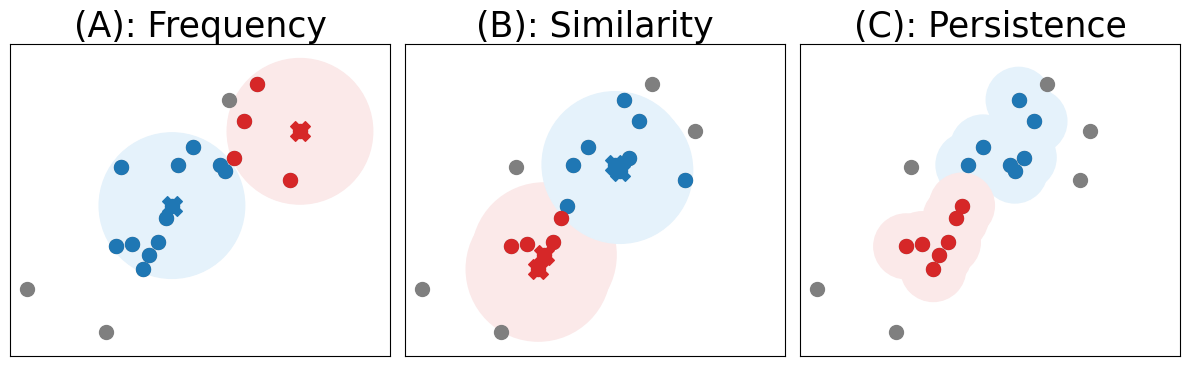

In [2]:
from scipy.spatial.distance import cdist
np.random.seed(9)
n_points = 20
arr1 = np.random.randn(10,2).T + [[1.5],[1.5]]
arr2 = np.random.randn(10,2).T - [[1.5],[1.5]]
points = np.hstack((arr1,arr2)).T


fig,axs = plt.subplots(1,3,figsize=(12,4),sharex=True,sharey=True)
#dmin = np.min(points) - 0.05
#dmax = np.max(points) + 0.05
#axs[0].set_xlim(dmin,dmax)
#axs[0].set_ylim(dmin,dmax)

# density based 
cdis = cdist(points,points,"euclidean")
threshold = 2
counts = np.sum(cdis<threshold,axis=1)
idx1 = np.argmax(counts)
for idx in np.argsort(counts)[::-1][1:]: 
    if cdis[idx1,idx]> 2*threshold:
        idx2 = idx
        break

set1 = []
for point in points: 
    if np.linalg.norm(point - points[idx1])<threshold: 
        set1.append(point)
set1 = np.array(set1)

set2 = []
for point in points: 
    if np.linalg.norm(point - points[idx2])<threshold: 
        set2.append(point)
set2 = np.array(set2)

circle1 = plt.Circle(points[idx1],threshold,color = "#e5f2fb")
circle2 = plt.Circle(points[idx2],threshold,color = "#fbe9e9")
axs[0].add_patch(circle1)
axs[0].add_patch(circle2)
axs[0].scatter(*points.T, 100,color = "tab:grey")
axs[0].scatter(*set1.T,100,color="tab:blue")
axs[0].scatter(*points[idx1],200,color="tab:blue",marker= "X")
axs[0].scatter(*set2.T,100,color="tab:red")
axs[0].scatter(*points[idx2],200,color="tab:red",marker= "X")
axs[0].set_aspect("equal")


#distance based
np.fill_diagonal(cdis,np.inf)
idx11,idx12 = np.unravel_index(np.argmin(cdis),cdis.shape)

set1 = []
for p in points: 
    if (np.linalg.norm(p-points[idx11])<threshold) + (np.linalg.norm(p-points[idx12])<threshold): 
        set1.append(p)
set1 = np.array(set1)

rpoints = []
for p in points: 
    if (np.linalg.norm(p-points[idx11])>threshold) * (np.linalg.norm(p-points[idx12])>threshold): 
        rpoints.append(p)
rpoints = np.array(rpoints)
rcdis = cdist(rpoints,rpoints)
np.fill_diagonal(rcdis,np.inf)
idx21,idx22 = np.unravel_index(np.argmin(rcdis),rcdis.shape)

set2 = []
for p in rpoints: 
    if (np.linalg.norm(p-rpoints[idx21])<threshold) + (np.linalg.norm(p-rpoints[idx22])<threshold): 
        set2.append(p)
set2 = np.array(set2)

circle21 = plt.Circle(rpoints[idx21],threshold,facecolor = "#fbe9e9")
circle22 = plt.Circle(rpoints[idx22],threshold,facecolor = "#fbe9e9")
axs[1].add_patch(circle21)
axs[1].add_patch(circle22)
circle11 = plt.Circle(points[idx11],threshold,color = "#e5f2fb")
circle12 = plt.Circle(points[idx12],threshold,color = "#e5f2fb")
axs[1].add_patch(circle11)
axs[1].add_patch(circle12)
axs[1].scatter(*points.T,100,color = "tab:grey")
axs[1].scatter(*set1.T,100,color="tab:blue")
axs[1].scatter(*points[idx11],200,color="tab:blue",marker= "X")
axs[1].scatter(*points[idx12],200,color="tab:blue",marker= "X")
axs[1].scatter(*set2.T,100,color="tab:red")
axs[1].scatter(*rpoints[idx21],200,color="tab:red",marker= "X")
axs[1].scatter(*rpoints[idx22],200,color="tab:red",marker= "X")
axs[1].set_aspect("equal")


from src.persistence import BasicPersistence,ThresholdPersistenceMST
from src.threshold import otsu_jump

i1,i2 = np.triu_indices(n_points,1)
filtration = np.vstack((i1,i2,cdis[i1,i2])).T
filtration = filtration[np.argsort(filtration[:,2])]
bp = BasicPersistence()
bp.fit(filtration)
bp.persistence_diagram()
pers = bp.get_persistence(True)
pcut,bcut = otsu_jump(pers[:-1,:-1])
idxs = np.where(pers[:,0]<bcut)[0]
arr = pers[idxs]
arr = np.sort(arr[:,1]- arr[:,0])[::-1]
pcut = (arr[1]+arr[2])/2
tp = ThresholdPersistenceMST(pcut,bcut)
tp.fit(bp.mst_)

colors = ["#e5f2fb","#fbe9e9"]
for i,(key,lst)in enumerate(tp.connected_components_.items()): 
    for idx in lst:
        c = plt.Circle(points[idx],bcut,color = colors[i]) 
        axs[2].add_patch(c)
axs[2].scatter(*points.T,100,color = "tab:grey")
colors = ["tab:blue", "tab:red"]
for i,(key,lst)in enumerate(tp.connected_components_.items()): 
    for idx in lst: 
        axs[2].scatter(*points[idx],100,color = colors[i])

for ax in axs:         
    ax.set_aspect("equal")
    ax.set_xticks([])
    ax.set_yticks([])

axs[0].set_title("(A): Frequency",fontsize=25)
axs[1].set_title("(B): Similarity",fontsize=25)
axs[2].set_title("(C): Persistence", fontsize=25)
fig.tight_layout()

plt.savefig("pictures/cluster.pdf",format="pdf")


# Method overview

In [3]:
N_PATTERN = 2
WLEN = 100

np.random.seed(2)
sg = SignalGenerator(N_PATTERN,WLEN,motif_fundamental=4,sparsity=2,sparsity_fluctuation=0.5,walk_amplitude=0.2,max_rep=4,min_rep=3,motif_amplitude=1,noise_amplitude=0.5)
signal,label = sg.generate()
sg.plot()

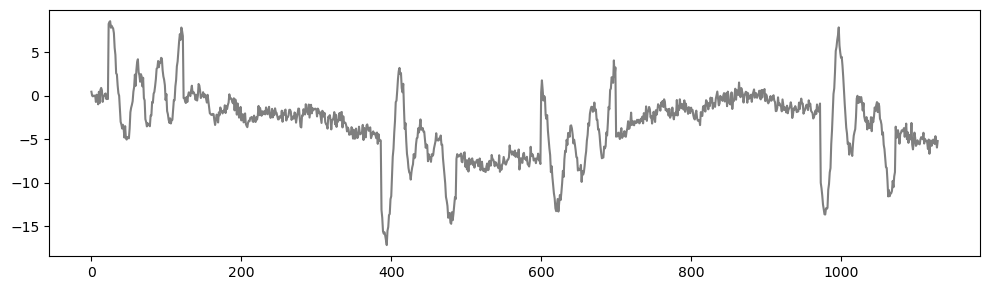

In [4]:
fig,ax = plt.subplots(1,1,figsize =(10,3))
ax.plot(signal[800:1930], color = "tab:grey")
fig.tight_layout()
plt.savefig("pictures/r_signal.pdf",format="pdf",transparent=True)

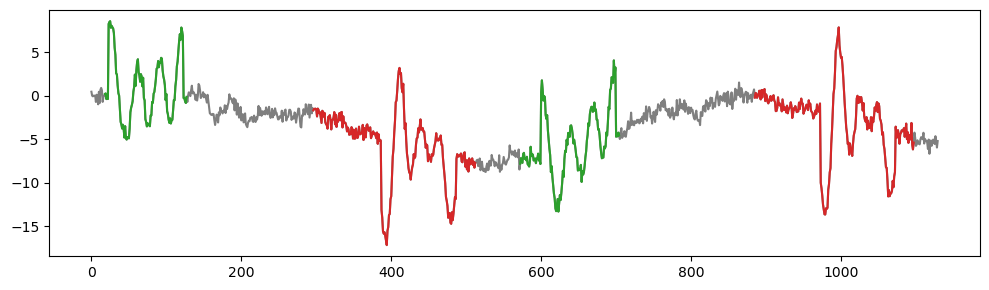

In [5]:
bpp = BasePersistentPattern(WLEN,5,jump=1,alpha=10)
bpp.fit(signal)

fig,ax = plt.subplots(1,1,figsize =(10,3))
ax.plot(signal[800:1930], color = "tab:grey")
cmap = plt.cm.tab10
for i,labels in enumerate(bpp.prediction_birth_list_[0]): 
    for (start,end) in labels: 
        if (start>=800)*(end<=1930):
            x = np.arange(start,end)-800
            y = signal[start:end]
            ax.plot(x,y,color = cmap((3-i)%10), label=f"Pattern {i}")

handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
fig.tight_layout()
plt.savefig("pictures/m_signal.pdf",format="pdf",transparent=True)

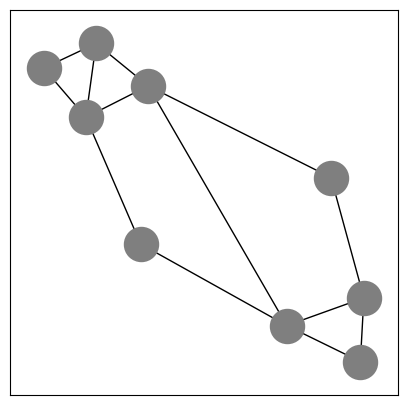

In [6]:
g = nx.Graph()
g.add_nodes_from([i for i in range(9)])
g.add_edge(0,1, weight=2)
g.add_edge(0,2, weight=3)
g.add_edge(2,1, weight=3)
g.add_edge(3,4, weight=1)
g.add_edge(5,6, weight=2)
#g.add_edge(3,5, weight=2)
g.add_edge(3,6, weight=3)
g.add_edge(4,5, weight=1)
g.add_edge(4,6, weight=3)
g.add_edge(7,1, weight=10)
g.add_edge(7,4, weight=15)
g.add_edge(8,0, weight=12)
g.add_edge(8,5, weight=15)
g.add_edge(1,5, weight=15)

g2 = nx.Graph()
g2.add_nodes_from([i for i in range(9)])
g2.add_edge(0,1, weight=10)
g2.add_edge(0,2, weight=8)
g2.add_edge(2,1, weight=10)
g2.add_edge(3,4, weight=8)
g2.add_edge(5,6, weight=8)
g2.add_edge(3,5, weight=8)
g2.add_edge(3,6, weight=8)
g2.add_edge(4,5, weight=10)
g2.add_edge(4,6, weight=8)
g2.add_edge(7,1, weight=3)
g2.add_edge(7,4, weight=3)
g2.add_edge(8,0, weight=3)
g2.add_edge(8,5, weight=2)
pos = nx.spring_layout(g2,seed=6)

fig, ax = plt.subplots(1, 1, figsize=(5, 5), facecolor="white")
nx.draw_networkx_nodes(g,pos, ax=ax, node_size=600, node_color="tab:grey")
nx.draw_networkx_edges(g,pos, ax=ax)
plt.savefig("pictures/r_graph.pdf",format="pdf",transparent=True)

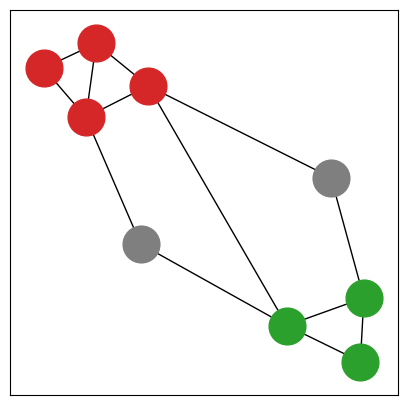

In [7]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5), facecolor="white")
nx.draw_networkx_nodes(g, pos, nodelist=[0,1,2], node_color="tab:green", node_size=700)
nx.draw_networkx_nodes(g, pos, nodelist=[3,4,5,6], node_color="tab:red", node_size=700)
nx.draw_networkx_nodes(g, pos, nodelist=[7,8], node_color="tab:grey", node_size=700)
nx.draw_networkx_edges(g,pos)
plt.savefig("pictures/m_graph.pdf",format="pdf",transparent=True)

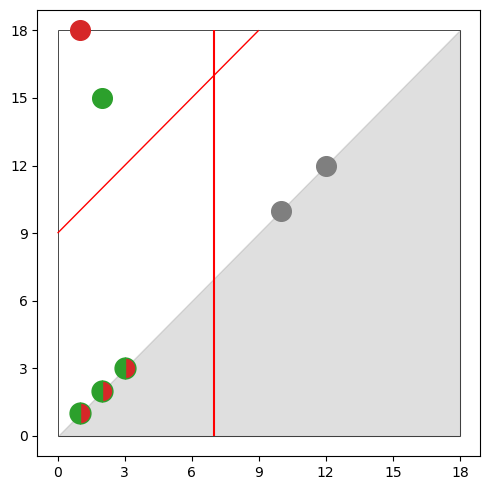

In [8]:
from matplotlib.lines import Line2D
fig,ax = plt.subplots(1,1,figsize = (5,5))

marker_style = dict(color='tab:green', marker='o',markersize=15, markerfacecoloralt='tab:red')

p0 = Polygon([[0,0],[2,0],[2,2]],color = 'grey', alpha=0.25)
ax.add_patch(p0)
ax.hlines(2,0,2,color="black", lw = 0.5,zorder=1)
ax.hlines(0,0,2,color="black", lw = 0.5,zorder=1)
ax.vlines(2,0,2,color="black", lw = 0.5,zorder=1)
ax.vlines(0,0,2,color="black", lw = 0.5,zorder=1)
ax.scatter(1/9,2,200,color = "tab:red",zorder=2)
ax.scatter(2/9,15/9,200,color = "tab:green",zorder=2)

ax.plot(2/9,2/9,zorder=2,fillstyle = "left", **marker_style)
ax.plot(1/9,1/9,zorder=2,fillstyle = "left", **marker_style)
ax.plot(3/9,3/9,zorder=2,fillstyle = "left", **marker_style)
ax.scatter(10/9,10/9,200,color = "tab:grey",zorder=2)
ax.scatter(12/9,12/9,200,color = "tab:grey",zorder=2)

ax.vlines(7/9,0,2,color="red",zorder=3)
p2 = Polygon([[0,1],[2-1,2]], color = "red",zorder = 3)
ax.add_patch(p2)

ax.set_xticks(np.linspace(0,2,7))
ax.set_xticklabels([0,3,6,9,12,15,18])

ax.set_yticks(np.linspace(0,2,7))
ax.set_yticklabels([0,3,6,9,12,15,18])
    
fig.tight_layout()
plt.savefig("pictures/pd.pdf",format="pdf")

# Distance description

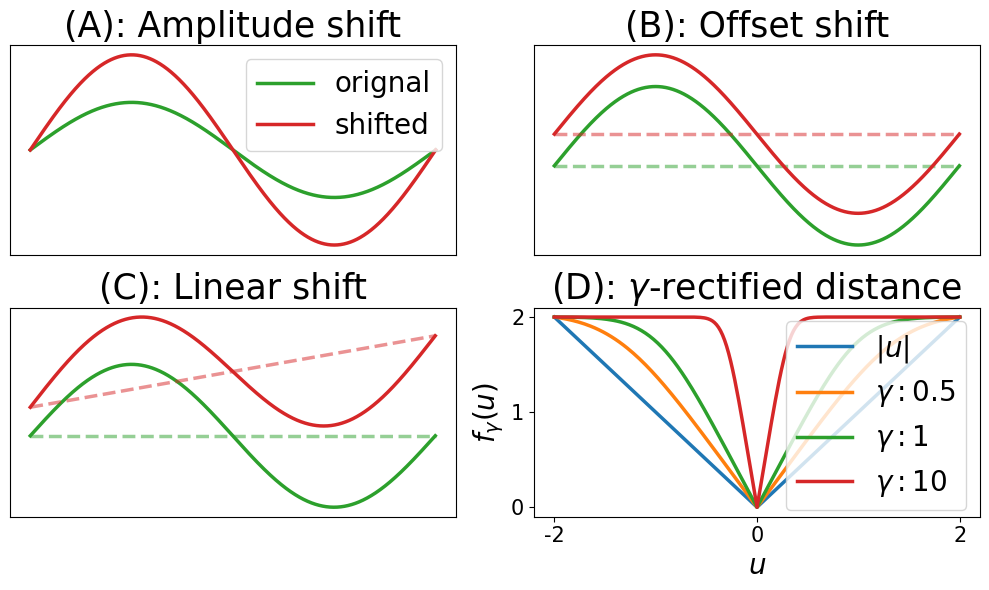

In [9]:
fig,axs = plt.subplots(2,2,figsize = (10,6),sharex=False, sharey=False)
t = np.linspace(0,2*np.pi,1000)
s = np.sin(t)

axs[0,0].plot(s,color = "tab:green",label="orignal",linewidth=2.5)
axs[0,0].plot(2*s,color = "tab:red",label = "shifted",linewidth=2.5)

offset = 0.4
axs[0,1].hlines(0,0,1000,color="tab:green",alpha = 0.5, linestyle = "--",linewidth=2.5)
axs[0,1].plot(s,color = "tab:green",linewidth=2.5)
axs[0,1].hlines(offset,0,1000,color="tab:red",alpha = 0.5, linestyle = "--",linewidth=2.5)
axs[0,1].plot(s +offset,color = "tab:red",linewidth=2.5)

lt = 1*np.linspace(0,1,1000) + 0.4
axs[1,0].hlines(0,0,1000,color="tab:green",alpha = 0.5, linestyle = "--",linewidth=2.5)
axs[1,0].plot(s,color = "tab:green",linewidth=2.5)
axs[1,0].plot(lt,color="tab:red",alpha = 0.5, linestyle = "--",linewidth=2.5)
axs[1,0].plot(s+lt,color = "tab:red",linewidth=2.5)

#axs[0,0].plot(s,color = "tab:blue",label="orignal",linewidth=2.5)
#axs[0,0].plot(s+np.random.randn(1000)*0.01,color = "tab:orange",label = "shifted",linewidth=2.5)

dist = lambda x,gamma : 2* np.sqrt(np.tanh(gamma*x**2)/np.tanh(4*gamma))

x = np.linspace(-2,2,201)
#x = np.concatenate((x,x[::-1][1:]))
axs[1,1].plot(x,np.abs(x),label = r"$|u|$",linewidth=2.5)
axs[1,1].plot(x,dist(x,0.5),label= r"$\gamma: 0.5$",linewidth=2.5)
axs[1,1].plot(x,dist(x,1),label= r"$\gamma: 1$",linewidth=2.5)
axs[1,1].plot(x,dist(x,10),label= r"$\gamma: 10$",linewidth=2.5)

axs[0,0].set_title("(A): Amplitude shift",fontsize=25)
axs[0,1].set_title("(B): Offset shift",fontsize=25)
axs[1,0].set_title("(C): Linear shift",fontsize=25)
axs[1,1].set_title(r"(D): $\gamma$-rectified distance",fontsize=25)
axs[1,1].set_ylabel(r"$f_{\gamma}(u)$",fontsize=20)
axs[1,1].set_yticks([0,1,2])
axs[1,1].set_yticklabels([0,1,2],fontsize=15)
axs[1,1].set_xlabel(r"$u$",fontsize=20)
axs[1,1].set_xticks([-2,0,2])
axs[1,1].set_xticklabels([-2,0,2],fontsize=15)


axs[0,0].legend(fontsize=20)
axs[1,1].legend(fontsize=20)

for ax in axs.flat[:-1]:
    ax.set_xticks([])
    ax.set_yticks([])
fig.tight_layout()
plt.savefig("pictures/distance.pdf",format="pdf")

# Persistence description

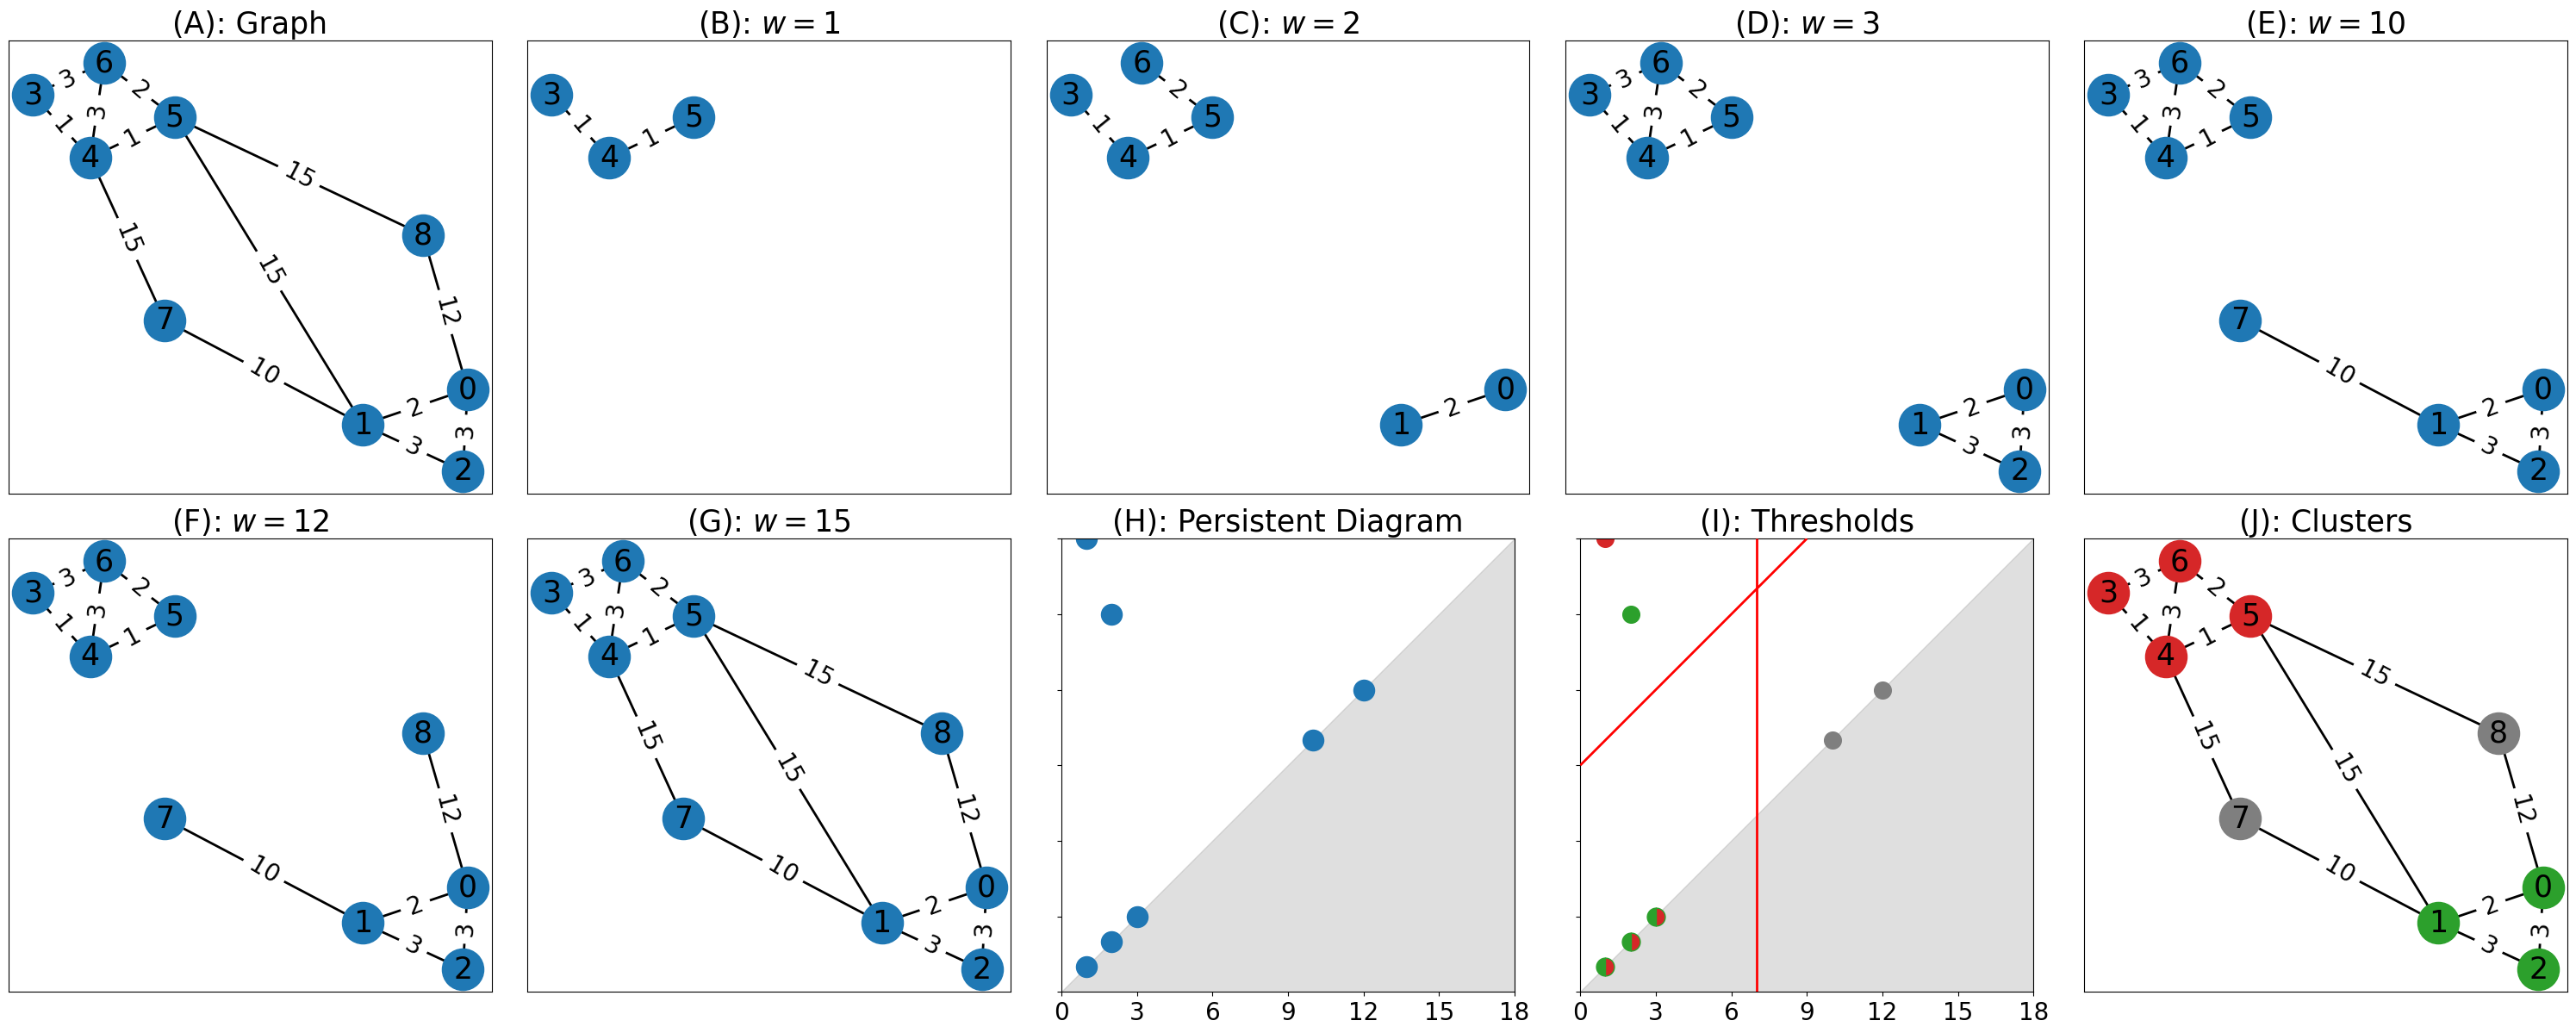

In [10]:
fig, axs = plt.subplots(2, 5, figsize=(30, 12), facecolor="white",sharex=True,sharey=True)

g = nx.Graph()
g.add_nodes_from([i for i in range(9)])
g.add_edge(0,1, weight=2)
g.add_edge(0,2, weight=3)
g.add_edge(2,1, weight=3)
g.add_edge(3,4, weight=1)
g.add_edge(5,6, weight=2)
g.add_edge(3,6, weight=3)
g.add_edge(4,5, weight=1)
g.add_edge(4,6, weight=3)
g.add_edge(7,1, weight=10)
g.add_edge(7,4, weight=15)
g.add_edge(8,0, weight=12)
g.add_edge(8,5, weight=15)
g.add_edge(1,5, weight=15)

#set node position
g2 = nx.Graph()
g2.add_nodes_from([i for i in range(9)])
g2.add_edge(0,1, weight=10)
g2.add_edge(0,2, weight=8)
g2.add_edge(2,1, weight=10)
g2.add_edge(3,4, weight=8)
g2.add_edge(5,6, weight=8)
g2.add_edge(3,5, weight=8)
g2.add_edge(3,6, weight=8)
g2.add_edge(4,5, weight=10)
g2.add_edge(4,6, weight=8)
g2.add_edge(7,1, weight=3)
g2.add_edge(7,4, weight=3)
g2.add_edge(8,0, weight=3)
g2.add_edge(8,5, weight=2)
pos = nx.spring_layout(g2,seed=6)

xl = []
yl = []
for k,(x,y) in pos.items():
    xl.append(x)
    yl.append(y)

for k,(x,y) in pos.items():
    pos[k][0] = 1.8*(x - np.min(xl))/(np.max(xl)-np.min(xl))+0.1
    pos[k][1] = 1.8*(y - np.min(yl))/(np.max(yl)-np.min(yl))+0.1

nx.draw_networkx_nodes(g,pos, ax=axs[0,0], node_size=1200)
nx.draw_networkx_edges(g,pos, ax=axs[0,0],width=2)
nx.draw_networkx_labels(g,pos,ax=axs[0,0], font_size = 25)
labels = nx.get_edge_attributes(g,'weight')
nx.draw_networkx_edge_labels(g,pos,edge_labels=labels,ax=axs[0,0], font_size = 20)
axs[0,0].set_title("(A): Graph",fontsize=25)

g3 = g.edge_subgraph([(3, 4), (4,5)])
nx.draw_networkx_nodes(g3,pos, ax=axs[0,1], node_size=1200)
nx.draw_networkx_edges(g3,pos, ax=axs[0,1],width=2)
nx.draw_networkx_labels(g3,pos,ax=axs[0,1], font_size = 25)
labels = nx.get_edge_attributes(g3,'weight')
nx.draw_networkx_edge_labels(g3,pos,edge_labels=labels,ax=axs[0,1], font_size = 20)
axs[0,1].set_title(r"(B): $w = 1$",fontsize=25)

g3 = g.edge_subgraph([(0, 1), (3, 4), (4,5),(5,6)])
nx.draw_networkx_nodes(g3,pos, ax=axs[0,2], node_size=1200)
nx.draw_networkx_edges(g3,pos, ax=axs[0,2],width=2)
nx.draw_networkx_labels(g3,pos,ax=axs[0,2], font_size = 25)
labels = nx.get_edge_attributes(g3,'weight')
nx.draw_networkx_edge_labels(g3,pos,edge_labels=labels,ax=axs[0,2], font_size = 20)
axs[0,2].set_title(r"(C): $w = 2$",fontsize=25)

g3 = g.edge_subgraph([(0, 1), (3, 4), (4,5), (0,2),(1,2),(5,6),(3,6),(4,6)])
nx.draw_networkx_nodes(g3,pos, ax=axs[0,3], node_size=1200)
nx.draw_networkx_edges(g3,pos, ax=axs[0,3],width=2)
nx.draw_networkx_labels(g3,pos,ax=axs[0,3], font_size = 25)
labels = nx.get_edge_attributes(g3,'weight')
nx.draw_networkx_edge_labels(g3,pos,edge_labels=labels,ax=axs[0,3], font_size = 20)
axs[0,3].set_title(r"(D): $w = 3$",fontsize=25)


g3 = g.edge_subgraph([(0, 1), (3, 4), (4,5), (0,2),(1,2),(5,6),(3,6),(4,6),(1,7)])
nx.draw_networkx_nodes(g3,pos, ax=axs[0,4], node_size=1200)
nx.draw_networkx_edges(g3,pos, ax=axs[0,4],width=2)
nx.draw_networkx_labels(g3,pos,ax=axs[0,4], font_size = 25)
labels = nx.get_edge_attributes(g3,'weight')
nx.draw_networkx_edge_labels(g3,pos,edge_labels=labels,ax=axs[0,4], font_size = 20)
axs[0,4].set_title(r"(E): $w = 10$",fontsize=25)


g3 = g.edge_subgraph([(0, 1), (3, 4), (4,5), (0,2),(1,2),(5,6),(3,6),(4,6),(1,7),(0,8)])
nx.draw_networkx_nodes(g3,pos, ax=axs[1,0], node_size=1200)
nx.draw_networkx_edges(g3,pos, ax=axs[1,0],width=2)
nx.draw_networkx_labels(g3,pos,ax=axs[1,0], font_size = 25)
labels = nx.get_edge_attributes(g3,'weight')
nx.draw_networkx_edge_labels(g3,pos,edge_labels=labels,ax=axs[1,0], font_size = 20)
axs[1,0].set_title(r"(F): $w= 12$",fontsize=25)


g3 = g.edge_subgraph([(0, 1), (3, 4), (4,5), (0,2),(1,2),(5,6),(3,6),(4,6),(1,7),(0,8),(4,7),(5,8),(1,5)])
nx.draw_networkx_nodes(g3,pos, ax=axs[1,1], node_size=1200)
nx.draw_networkx_edges(g3,pos, ax=axs[1,1],width=2)
nx.draw_networkx_labels(g3,pos,ax=axs[1,1], font_size = 25)
labels = nx.get_edge_attributes(g3,'weight')
nx.draw_networkx_edge_labels(g3,pos,edge_labels=labels,ax=axs[1,1], font_size = 20)
axs[1,1].set_title(r"(G): $w= 15$",fontsize=25)

p0 = Polygon([[0,0],[2,0],[2,2]],color = 'grey', alpha=0.25)
axs[1,2].add_patch(p0)

axs[1,2].scatter(1/9,2,300,color = "tab:blue",zorder=2)
axs[1,2].scatter(2/9,15/9,300,color = "tab:blue",zorder=2)
axs[1,2].scatter(2/9,2/9,300,color = "tab:blue",zorder=2)
axs[1,2].scatter(1/9,1/9,300,color = "tab:blue",zorder=2)
axs[1,2].scatter(3/9,3/9,300,color = "tab:blue",zorder=2)
axs[1,2].scatter(10/9,10/9,300,color = "tab:blue",zorder=2)
axs[1,2].scatter(12/9,12/9,300,color = "tab:blue",zorder=2)



axs[1,2].set_xticks(np.linspace(0,2,7))
axs[1,2].set_xticklabels([0,3,6,9,12,15,18],fontsize=20)
axs[1,2].set_yticks(np.linspace(0,2,7))
axs[1,2].set_yticklabels([0,3,6,9,12,15,18])
axs[1,2].set_aspect("equal") 
axs[1,2].set_title("(H): Persistent Diagram",fontsize=25)

#second with threshold

marker_style = dict(color='tab:green', marker='o',markersize=15, markerfacecoloralt='tab:red')

p0 = Polygon([[0,0],[2,0],[2,2]],color = 'grey', alpha=0.25)
axs[1,3].add_patch(p0)
axs[1,3].scatter(1/9,2,200,color = "tab:red",zorder=2)
axs[1,3].scatter(2/9,15/9,200,color = "tab:green",zorder=2)

axs[1,3].plot(2/9,2/9,zorder=2,fillstyle = "left", **marker_style)
axs[1,3].plot(1/9,1/9,zorder=2,fillstyle = "left", **marker_style)
axs[1,3].plot(3/9,3/9,zorder=2,fillstyle = "left", **marker_style)
axs[1,3].scatter(10/9,10/9,200,color = "tab:grey",zorder=2)
axs[1,3].scatter(12/9,12/9,200,color = "tab:grey",zorder=2)


axs[1,3].vlines(7/9,0,2,color="red",zorder=3,linewidth =2)
p2 = Polygon([[0,1],[2-1,2]], color = "red",zorder = 3,linewidth=2)
axs[1,3].add_patch(p2)

axs[1,3].set_xticks(np.linspace(0,2,7))
axs[1,3].set_xticklabels([0,3,6,9,12,15,18],fontsize=20)
axs[1,3].set_yticks(np.linspace(0,2,7))
axs[1,3].set_yticklabels([0,3,6,9,12,15,18])
axs[1,3].set_aspect("equal") # forces to be square shaped

# We can modify the title, aspect, etc.
axs[1,3].set_title("(I): Thresholds",fontsize=25)
axs[1,3].set_xlim(0,2)
axs[1,3].set_ylim(0,2)

nx.draw_networkx_nodes(g, pos,ax=axs[1,4], nodelist=[0,1,2], node_color="tab:green", node_size=1200)
nx.draw_networkx_nodes(g, pos,ax=axs[1,4], nodelist=[3,4,5,6], node_color="tab:red", node_size=1200)
nx.draw_networkx_nodes(g, pos,ax=axs[1,4], nodelist=[7,8], node_color="tab:grey", node_size=1200)
nx.draw_networkx_edges(g,pos,ax=axs[1,4],width=2)
nx.draw_networkx_labels(g,pos,ax=axs[1,4], font_size = 25)
labels = nx.get_edge_attributes(g,'weight')
nx.draw_networkx_edge_labels(g,pos,edge_labels=labels,ax=axs[1,4], font_size = 20)
axs[1,4].set_title("(J): Clusters",fontsize=25)
fig.tight_layout()

plt.savefig("pictures/filtration.pdf",format="pdf")



# Threshold description

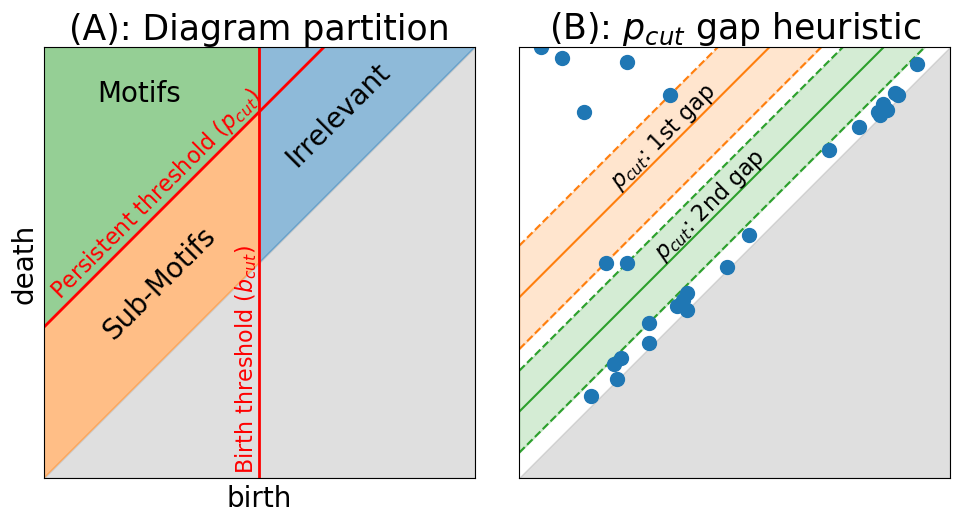

In [11]:
fig,axs = plt.subplots(1,2,figsize = (10,5))
p0 = Polygon([[0,0],[2,0],[2,2]],color = 'grey', alpha=0.25)
p1 = Polygon([[1,2],[1,1],[2,2]],color = 'tab:blue', alpha=0.5)
p2 = Polygon([[0,0],[1,1],[1,1.7],[0,0.7]],color = 'tab:orange', alpha=0.5)
p3 = Polygon([[0,0.7],[1,1.7],[1,2],[0,2]],color = 'tab:green', alpha=0.5)
axs[0].add_patch(p0)
axs[0].add_patch(p1)
axs[0].add_patch(p2)
axs[0].add_patch(p3)
axs[0].plot([0,2-0.7],[0.7,2], color="red",linewidth=2)
axs[0].plot([1,1],[0,2],color="red",linewidth=2)
axs[0].set_ylim(0,2)
axs[0].set_xlim(0,2)
axs[0].set_xticks([])
axs[0].set_yticks([])
axs[0].set_xlabel("birth", fontsize = 20)
axs[0].set_ylabel("death", fontsize = 20)
axs[0].text(1.1,1.45,"Irrelevant", fontsize = 20, rotation = 45)
axs[0].text(0.25,0.65,"Sub-Motifs", fontsize = 20, rotation = 45)
axs[0].text(0.25,1.75,"Motifs", fontsize = 20, rotation = 0)
axs[0].text(0.01,0.84,r"Persistent threshold $(p_{cut})$", fontsize = 16, rotation = 45, color = "red")
axs[0].text(0.88,0.05,r"Birth threshold $(b_{cut})$", fontsize = 16, rotation = 90, color = "red")
axs[0].set_xlim(0,2)
axs[0].set_ylim(0,2)
axs[0].set_title("(A): Diagram partition",fontsize=25)
axs[0].set_aspect("equal") 

p4 = Polygon([[0,0],[2,0],[2,2]],color = 'grey', alpha=0.25)
axs[1].add_patch(p4)

x = np.array([
    [0.1,1.9],
    [0.2,1.75],
    [0.3,1.4],
    [0.4,0.6],
    [0.5,0.5],
    [0.6,0.12],
    [0.5,1.43],
    [0.7,1.08]

])

axs[1].plot([0,2-x[7,1]],[x[7,1],2],"--",color = "tab:orange",zorder=1)
axs[1].plot([0,2-x[3,1]],[x[3,1],2],"--",color = "tab:orange",zorder=1)
x1 = (x[7,1] + x[3,1])/2
axs[1].plot([0,2-x1],[x1,2],color = "tab:orange",zorder=1)
axs[1].fill_between([0,2-x[3,1]],[x[3,1],2],[x[7,1],2+x[7,1]-x[3,1]],color = "tab:orange", alpha = 0.2)
axs[1].text(0.4,x1+0.51,r"$p_{cut}$: 1st gap", fontsize = 16, rotation = 45, color = "black")
axs[1].plot([0,2-x[4,1]],[x[4,1],2],"--",color = "tab:green",zorder=1)
axs[1].plot([0,2-x[5,1]],[x[5,1],2],"--",color = "tab:green",zorder=1)
x2 = (x[4,1] + x[5,1])/2
axs[1].plot([0,2-x2],[x2,2],color = "tab:green",zorder=1)
axs[1].fill_between([0,2-x[5,1]],[x[5,1],2],[x[4,1],2+x[4,1]-x[5,1]],color = "tab:green", alpha = 0.2)
axs[1].text(0.6,x2+0.71,r"$p_{cut}$: 2nd gap", fontsize = 16, rotation = 45, color = "black")

base = np.vstack((np.random.rand(20)*1.9,np.random.rand(20)*0.1))
x = np.vstack((x,base.T))
x[:,1] = x[:,1] + x[:,0]

axs[1].scatter(*x.T,100)
axs[1].set_xlim(0,2)
axs[1].set_ylim(0,2)
axs[1].set_title(r"(B): $p_{cut}$ gap heuristic",fontsize=25)
axs[1].set_aspect("equal") 


for ax in axs.flat:
    ax.set_xticks([])
    ax.set_yticks([])

    
fig.tight_layout()

plt.savefig("pictures/diagrams.pdf",format="pdf")

# Example

In [12]:
def plot_persistence_diagram(bpp): 
    pers = bpp.get_persistence(True)[:,:-1]
    pers = pers[pers[:,1]-pers[:,0]!=0]
    mask1 = pers[:,0]>bpp.b_cut_
    mask1 += (pers[:,0]<= bpp.b_cut_) * ((pers[:,1] - pers[:,0])<=bpp.p_cut_)
    mask2 = (pers[:,0]<= bpp.b_cut_) * ((pers[:,1] - pers[:,0])>bpp.p_cut_) 

    fig,ax = plt.subplots(1,1,figsize = (4,4))
    cmap = plt.cm.tab10
    p0 = Polygon([[0,0],[2,0],[2,2]],color = 'grey', alpha=0.25)
    ax.add_patch(p0)
    ax.hlines(2,0,2,color="black", lw = 0.5,zorder=1)
    ax.hlines(0,0,2,color="black", lw = 0.5,zorder=1)
    ax.vlines(2,0,2,color="black", lw = 0.5,zorder=1)
    ax.vlines(0,0,2,color="black", lw = 0.5,zorder=1)
    ax.scatter(*pers[mask1].T, color = "tab:blue",zorder=2)
    idx1 = np.argsort(bpp.knn_.dists_[list(bpp.tpmst_.connected_components_.keys()),0])
    points = pers[mask2]
    points = points[np.argsort(points[:,0])]
    for i,(b,d) in zip(idx1,points):
        ax.scatter(b,d, color = cmap((i+2)%10),zorder=2)
    ax.vlines(bpp.b_cut_,0,2,color="red",zorder=3)
    p2 = Polygon([[0,bpp.p_cut_],[2-bpp.p_cut_,2]], color = "red",zorder = 3)
    ax.add_patch(p2)
    #ax.set_title("(A) Persistence diagram",fontsize=16)
    fig.tight_layout()

    return fig,ax

In [13]:
import os
import pickle
from methods import BasePersistentPattern
from plotting import plot_signal_pattern,plot_pattern

In [14]:
with open("dataset/mitdb800/dataset.pkl", "rb") as f: 
    data = pickle.load(f)

with open("dataset/mitdb800/labels.pkl", "rb") as f: 
    labels = pickle.load(f)


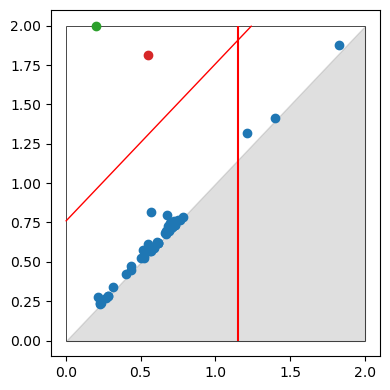

In [15]:
IDX = 50
MIN=15950
MAX = 17300
signal = data[IDX][MIN:MAX]
label = labels[IDX][:,MIN:MAX]
label = label[label.sum(axis=1)>0]

bpp = BasePersistentPattern(60,5,alpha=10)
bpp.fit(signal)

idx1 = np.argsort(bpp.knn_.dists_[list(bpp.tpmst_.connected_components_.keys()),0])
fig,axs = plot_persistence_diagram(bpp)
plt.savefig("pictures/illustrative_pd.pdf",format="pdf")

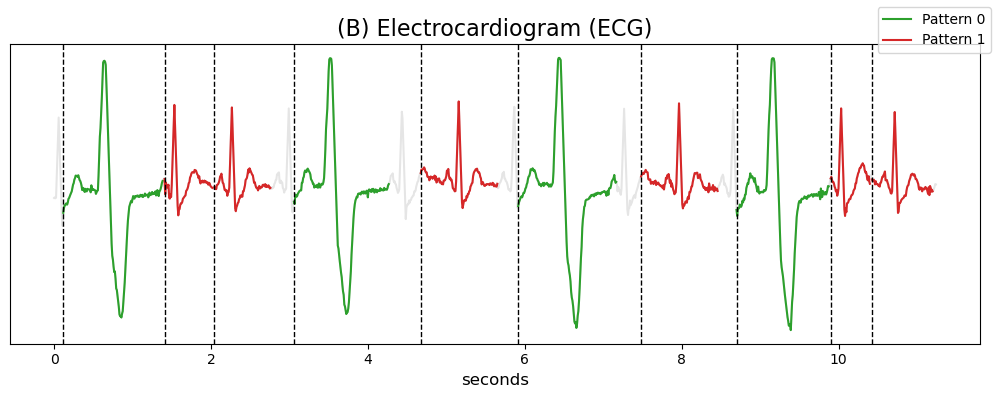

In [16]:
plot_signal_pattern(signal,*bpp.prediction_birth_list_,birth_aware=False,sampfreq=120, xlabel="seconds",title="(B) Electrocardiogram (ECG)")
plt.savefig("pictures/illustrative_signal.pdf",format="pdf")

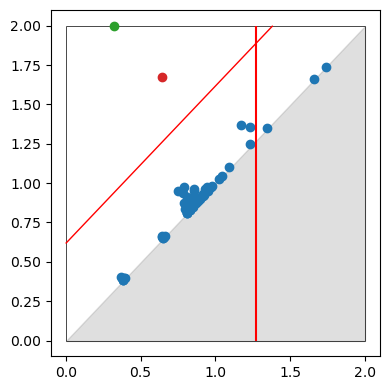

In [17]:
IDX = 1
MIN=0
MAX = 2000
signal = data[IDX][MIN:MAX]
label = labels[IDX][:,MIN:MAX]
label = label[label.sum(axis=1)>0]

bpp = BasePersistentPattern(60,5,alpha=10)
bpp.fit(signal)

idx1 = np.argsort(bpp.knn_.dists_[list(bpp.tpmst_.connected_components_.keys()),0])
plot_persistence_diagram(bpp)
plt.savefig("pictures/pd1.pdf",format="pdf")

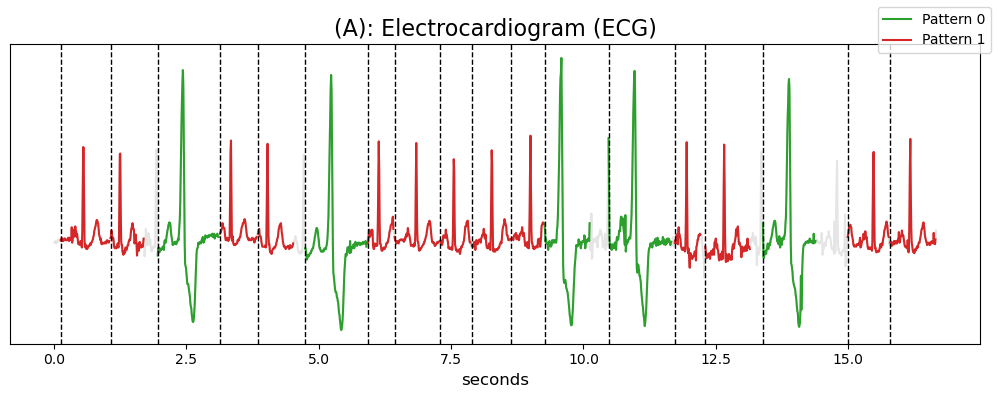

In [18]:
plot_signal_pattern(signal,*bpp.prediction_birth_list_,birth_aware=False,sampfreq=120, xlabel="seconds",title="(A): Electrocardiogram (ECG)")
plt.savefig("pictures/signal1.pdf",format="pdf")

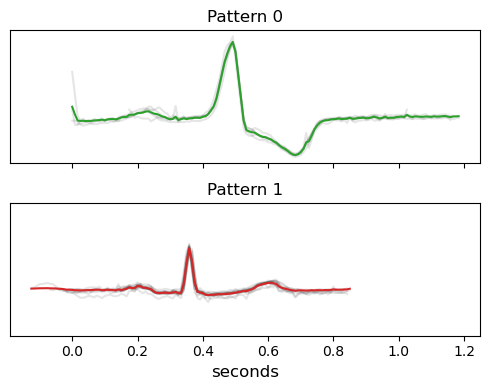

In [19]:
plot_pattern(signal,bpp.prediction_birth_list_[0],barycenter=True,sampfreq=120,xlabel="seconds")
plt.savefig("pictures/pattern1.pdf",format="pdf")

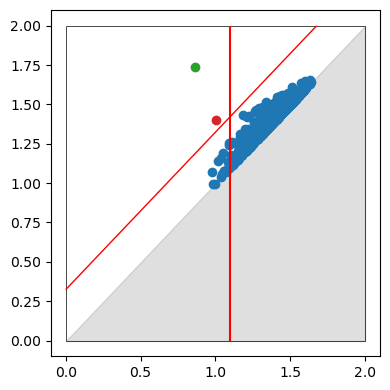

In [22]:
signal = pd.read_csv("dataset/nop141.txt",header=None).values.reshape(-1)
signal = -signal[50000:100000]
signal = (signal - np.mean(signal))/np.std(signal)
bpp = BasePersistentPattern(100,5,alpha=1,n_jobs=5,n_patterns=2)
bpp.fit(signal)
bpp.set_cut_values(b_cut=1.1)
plot_persistence_diagram(bpp)
plt.savefig("pictures/pd2.pdf",format="pdf")

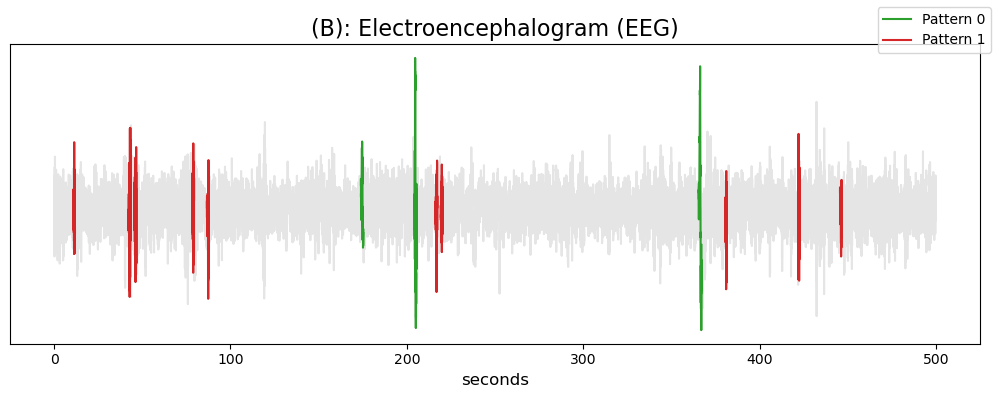

In [23]:
plot_signal_pattern(signal,*bpp.prediction_birth_list_,display_start=False,sampfreq=100,xlabel="seconds",birth_aware=False,title="(B): Electroencephalogram (EEG)")
plt.savefig("pictures/signal2.pdf",format="pdf")

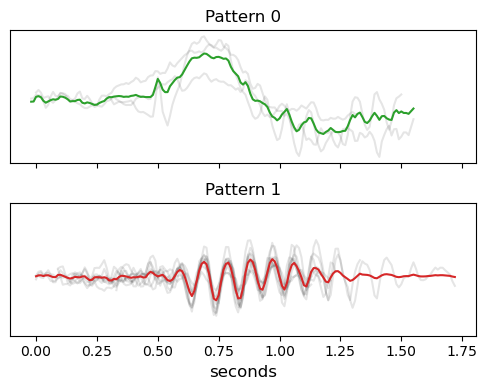

In [24]:
plot_pattern(signal,bpp.prediction_birth_list_[0],barycenter=True,xlabel="seconds",sampfreq=100)
plt.savefig("pictures/pattern2.pdf",format="pdf")